01_EDA_and_Preprocessing.ipynb

0. 노트북 개요

목적: 경구약제 이미지 객체 검출 대회용 전체 파이프라인(EDA→전처리→변환→학습→추론→제출)

입력: data/train_images, data/train_annotations(다단 폴더의 COCO JSON들), data/test_images

출력:

EDA 리포트(시각화 다수)

yolo_dataset/(images/labels, data.yaml 자동생성)

YOLOv8n / RT-DETR 추론 결과 CSV

두 모델 앙상블 CSV(최종 제출용)

In [8]:
# ==== 0-1. 루트 자동탐색 + 경로 설정 (맨 위에서 한 번만 실행) ====
from pathlib import Path
import os

def find_project_root(start: Path, max_up=6):
    cur = start.resolve()
    for _ in range(max_up + 1):
        if (cur / "data" / "train_images").exists():
            return cur
        cur = cur.parent
    return start.resolve()  # 못 찾으면 원래 위치

CWD = Path.cwd()
PROJ = find_project_root(CWD, max_up=6)

DATA = PROJ / "data"
TRAIN_IMG_DIR = DATA / "train_images"
TRAIN_ANN_DIR = DATA / "train_annotations"
TEST_IMG_DIR  = DATA / "test_images"

# 필요하면 작업폴더를 프로젝트 루트로 강제 변경(권장)
os.chdir(PROJ)

print("[현재 작업폴더(CWD)]", Path.cwd())
print("[프로젝트 루트]", PROJ)
print("[train_images 존재?]", TRAIN_IMG_DIR.exists(), "-", TRAIN_IMG_DIR)
print("[train_annotations 존재?]", TRAIN_ANN_DIR.exists(), "-", TRAIN_ANN_DIR)
print("[test_images 존재?]", TEST_IMG_DIR.exists(), "-", TEST_IMG_DIR)

# ── 절대경로로 강제 지정하고 싶으면 아래 3줄 중 원하는 것만 수정 후 주석 해제 ──
# TRAIN_IMG_DIR = Path("/여기에/절대경로/TABLET_PROJECT/data/train_images")
# TRAIN_ANN_DIR = Path("/여기에/절대경로/TABLET_PROJECT/data/train_annotations")
# TEST_IMG_DIR  = Path("/여기에/절대경로/TABLET_PROJECT/data/test_images")


[현재 작업폴더(CWD)] /Users/morgan/Desktop/tablet_project
[프로젝트 루트] /Users/morgan/Desktop/tablet_project
[train_images 존재?] True - /Users/morgan/Desktop/tablet_project/data/train_images
[train_annotations 존재?] True - /Users/morgan/Desktop/tablet_project/data/train_annotations
[test_images 존재?] True - /Users/morgan/Desktop/tablet_project/data/test_images


In [9]:
# ==== 0-2. train_annotations 아래 JSON 탐색(디버그) ====
from pathlib import Path

all_jsons = sorted([p for p in TRAIN_ANN_DIR.rglob("*.json")])
print("train_annotations에서 찾은 JSON:", len(all_jsons))
for p in all_jsons[:5]:
    print(" - 샘플:", p)

# 혹시 확장자가 .JSON 대문자일 때 대비
if len(all_jsons) == 0:
    up = sorted([p for p in TRAIN_ANN_DIR.rglob("*.JSON")])
    print("대문자 .JSON:", len(up))
    for p in up[:5]:
        print(" - 샘플:", p)
    if len(up) > 0:
        all_jsons = up

# 최후의 백업: 프로젝트 전체에서 train_annotations를 경로에 포함하는 json
if len(all_jsons) == 0:
    cand = sorted([p for p in PROJ.rglob("*.json") if "train_annotations" in str(p)])
    print("프로젝트 전체에서 찾은 후보:", len(cand))
    for p in cand[:5]:
        print(" - 샘플:", p)
    all_jsons = cand

if len(all_jsons) == 0:
    print("⚠️ 여전히 0개입니다. 경로/압축해제/폴더명 다시 확인 필요.")


train_annotations에서 찾은 JSON: 4526
 - 샘플: /Users/morgan/Desktop/tablet_project/data/train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json
 - 샘플: /Users/morgan/Desktop/tablet_project/data/train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_75_000_200.json
 - 샘플: /Users/morgan/Desktop/tablet_project/data/train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_90_000_200.json
 - 샘플: /Users/morgan/Desktop/tablet_project/data/train_annotations/K-001900-010224-016551-031705_json/K-016551/K-001900-010224-016551-031705_0_2_0_2_70_000_200.json
 - 샘플: /Users/morgan/Desktop/tablet_project/data/train_annotations/K-001900-010224-016551-031705_json/K-016551/K-001900-010224-016551-031705_0_2_0_2_75_000_200.json


1. 주석(JSON) 수집 & COCO 병합

train_annotations/ 하위 모든 폴더를 재귀 탐색하여 JSON 파일을 읽는다.

JSON마다 images, annotations, categories를 모아 단일 DataFrame으로 병합.

대회 설명에 맞춘 가공 규칙(고유 image_id, 정수형 category_id, bbox 유효성)을 검증.

In [10]:
# ==== 1. JSON 재귀 수집 및 병합 ====
json_paths = all_jsons  # 0-2 셀에서 스캔한 결과 사용
print(f"발견한 JSON 파일 수: {len(json_paths)}")


print(f"발견한 JSON 파일 수: {len(json_paths)}")

all_images, all_anns, all_cats = [], [], []
cat_name_to_id = {}  # category name → id(일관성 확인용)

# bbox 유효성 판단 함수
def is_valid_bbox(b):
    # COCO 형식: [x, y, w, h], 길이 4, 모두 양수(또는 0 이상)이고 w,h>0
    if not isinstance(b, list) or len(b) != 4:
        return False
    x, y, w, h = b
    return all([isinstance(v, (int, float)) for v in (x,y,w,h)]) and (w > 0) and (h > 0)

for jp in json_paths:
    try:
        d = json.loads(Path(jp).read_text())
    except Exception as e:
        print(f"[경고] JSON 읽기 실패: {jp} -> {e}")
        continue

    imgs = d.get("images", [])
    anns = d.get("annotations", [])
    cats = d.get("categories", [])

    # 카테고리 정합성(이름-아이디 쌍 유지) 체크
    for c in cats:
        cname = str(c.get("name"))
        cid   = int(c.get("id"))
        if cname in cat_name_to_id and cat_name_to_id[cname] != cid:
            print(f"[경고] 카테고리 '{cname}'의 id 불일치 발견: {cat_name_to_id[cname]} vs {cid} (파일: {jp})")
        cat_name_to_id.setdefault(cname, cid)

    # bbox 유효성 필터링 및 area 재계산(필요 시)
    valid_anns = []
    for a in anns:
        if "bbox" in a and is_valid_bbox(a["bbox"]):
            # area가 0이거나 누락되면 bbox로 재계산
            x,y,w,h = a["bbox"]
            a["area"] = float(w*h)
            valid_anns.append(a)
    if len(valid_anns) < len(anns):
        pass  # 무효 어노테이션이 제외되었음을 의미(로그 생략)

    all_images.extend(imgs)
    all_anns.extend(valid_anns)
    all_cats.extend(cats)

# DataFrame 화
df_imgs = pd.DataFrame(all_images)
df_anns = pd.DataFrame(all_anns)
df_cats = pd.DataFrame(all_cats).drop_duplicates(subset=["id"]).reset_index(drop=True)

print("images:", df_imgs.shape, "annotations(valid):", df_anns.shape, "categories:", df_cats.shape)

# 필수 필드 존재 여부 간단 점검
req_img_cols = ["id","file_name","width","height"]
print("필수 image 컬럼 모두 존재?", all(c in df_imgs.columns for c in req_img_cols))
print("필수 ann 컬럼 모두 존재?", all(c in df_anns.columns for c in ["image_id","category_id","bbox","area"]))


발견한 JSON 파일 수: 4526
발견한 JSON 파일 수: 4526
images: (4526, 50) annotations(valid): (4526, 8) categories: (73, 3)
필수 image 컬럼 모두 존재? True
필수 ann 컬럼 모두 존재? True


2. 이미지 기본 통계 & 시각화

해상도 분포, 가로/세로 비율, 파일별 객체 수, 객체 크기(면적/비율)

클래스 분포 상위/하위, 심한 불균형 확인

샘플 이미지에 바운딩박스 오버레이해서 확인

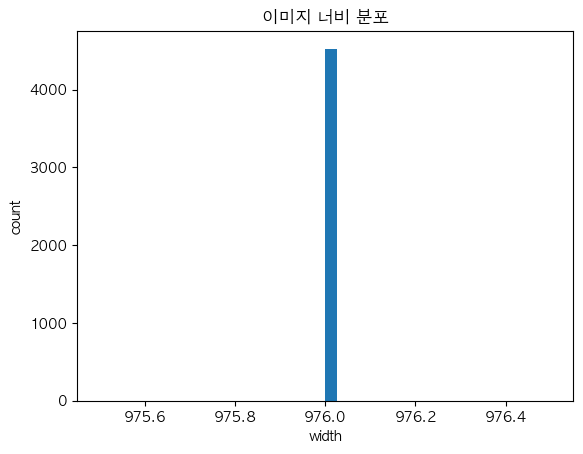

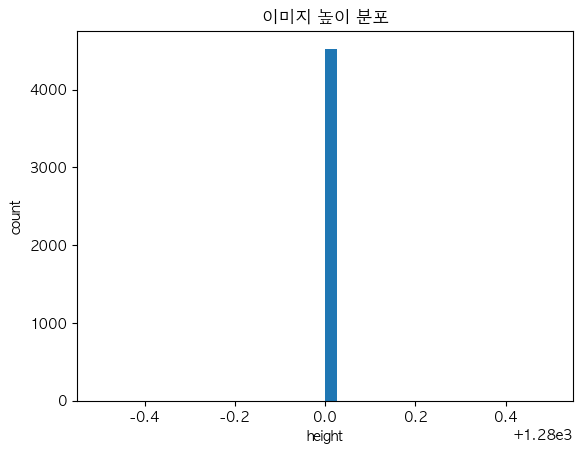

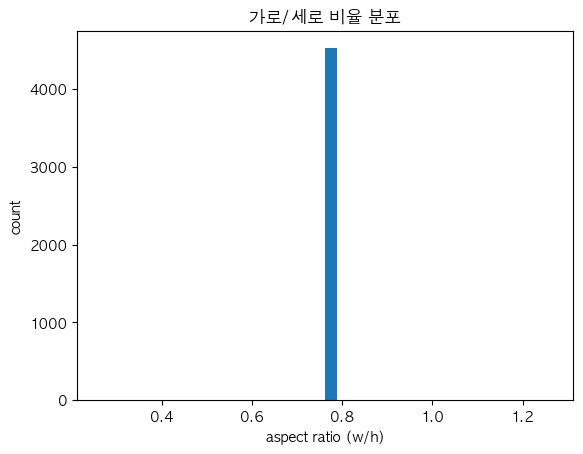

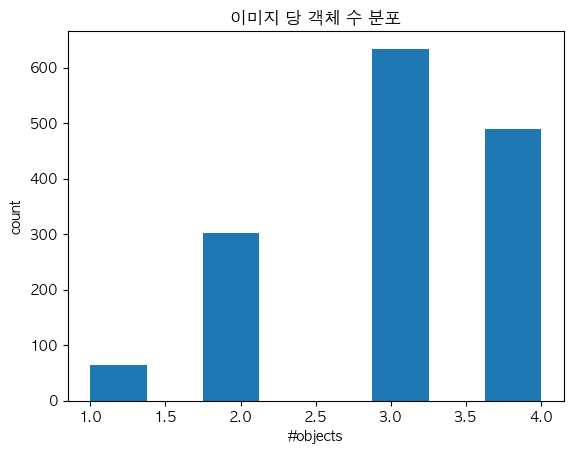

객체 수 요약:
 count    1489.000000
mean        3.039624
std         0.837889
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: num_objs, dtype: float64


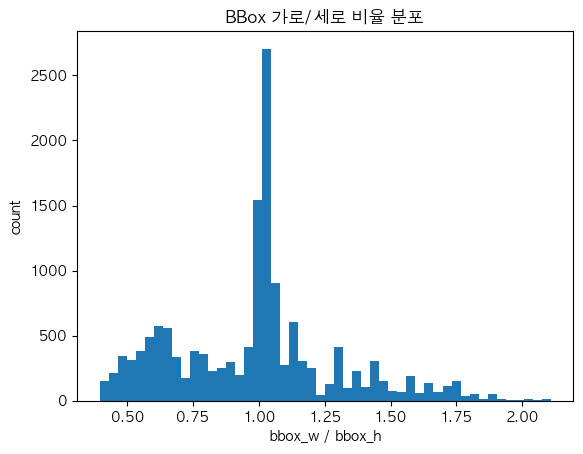

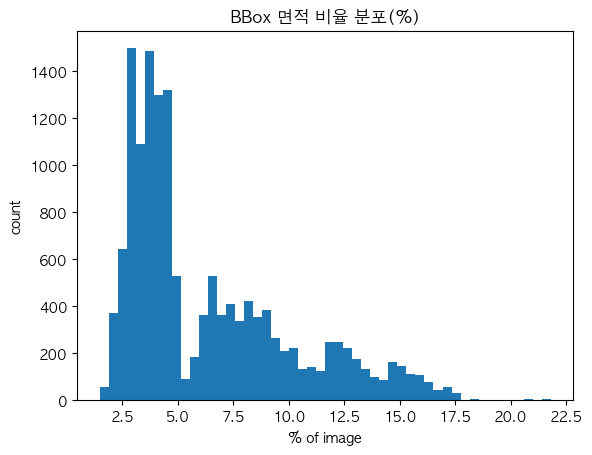

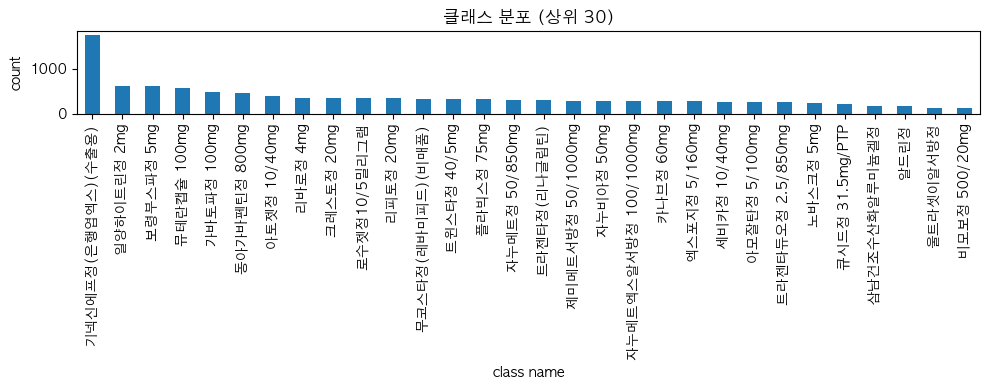

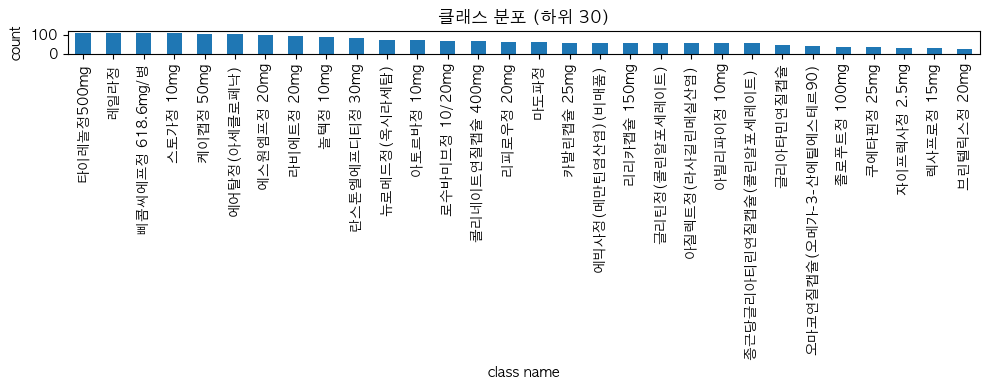

대략적인 불균형 비율(최다/최소): 72.46x


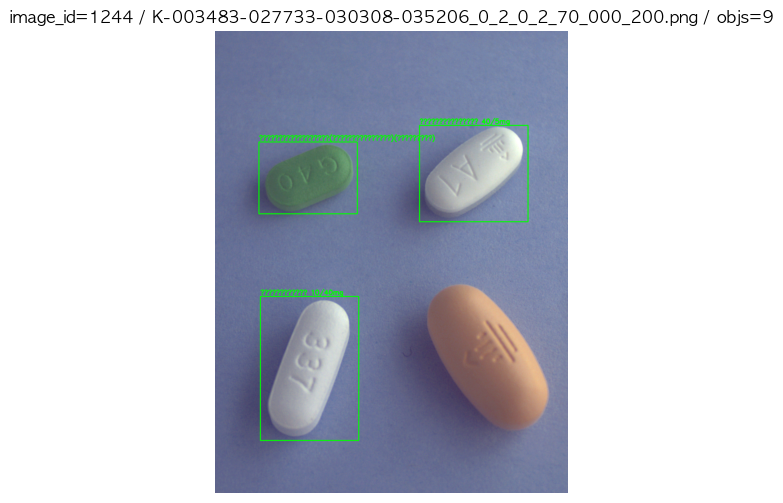

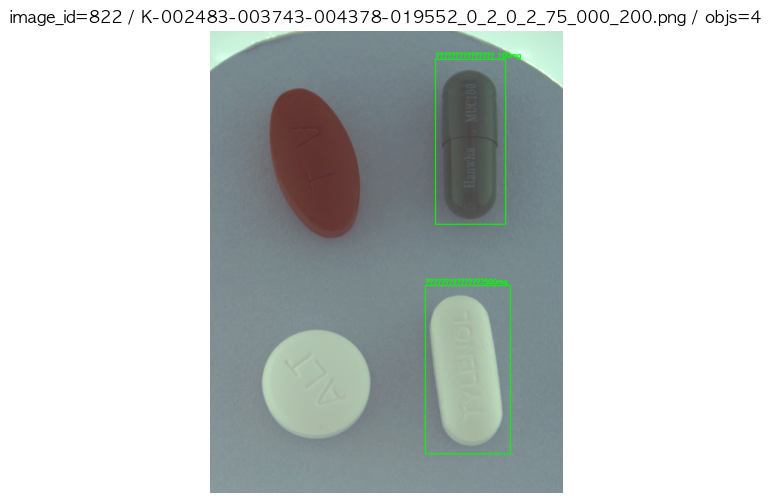

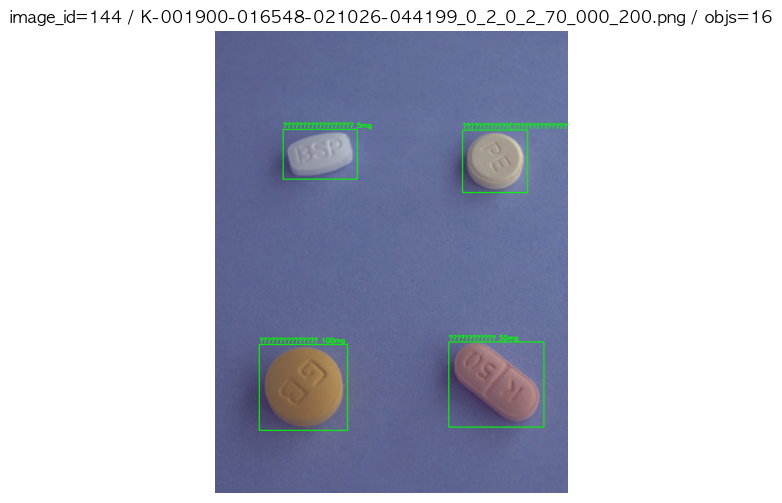

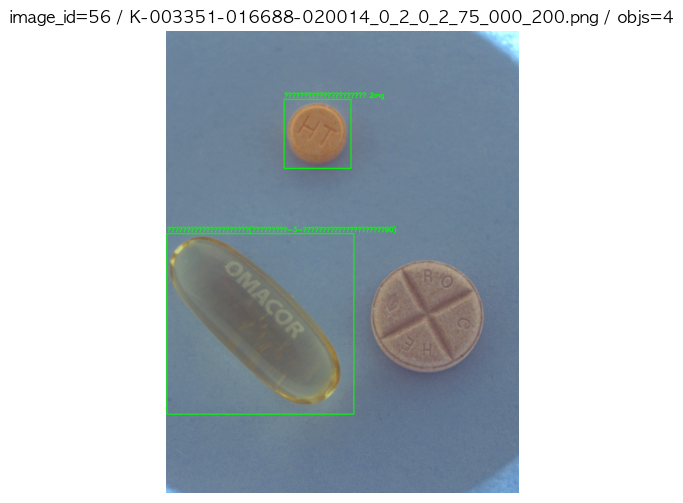

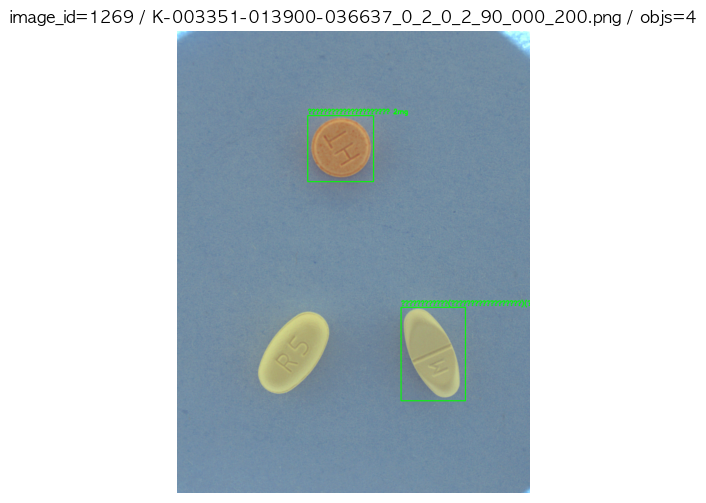

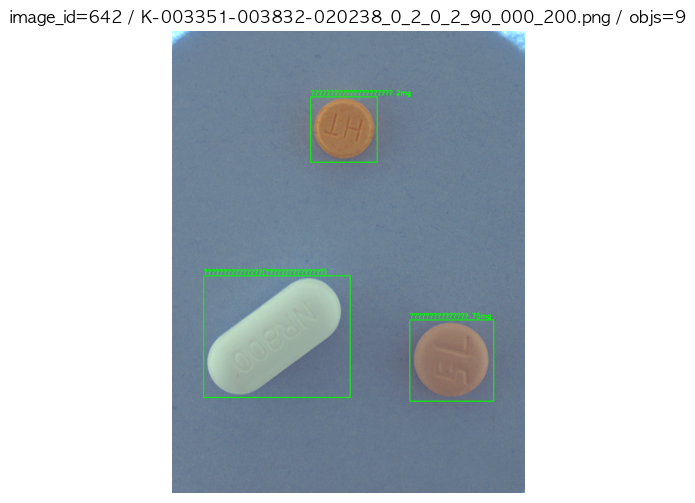

In [11]:
# ==== 2-1. 이미지 해상도/비율 통계 ====
df_imgs["aspect"] = df_imgs["width"] / df_imgs["height"]
fig = plt.figure()
plt.hist(df_imgs["width"], bins=40)
plt.title("이미지 너비 분포")
plt.xlabel("width"); plt.ylabel("count")
plt.show()

fig = plt.figure()
plt.hist(df_imgs["height"], bins=40)
plt.title("이미지 높이 분포")
plt.xlabel("height"); plt.ylabel("count")
plt.show()

fig = plt.figure()
plt.hist(df_imgs["aspect"], bins=40)
plt.title("가로/세로 비율 분포")
plt.xlabel("aspect ratio (w/h)"); plt.ylabel("count")
plt.show()

# ==== 2-2. 이미지당 객체 수 ====
img_obj_counts = df_anns.groupby("image_id")["id"].count().rename("num_objs")
fig = plt.figure()
plt.hist(img_obj_counts, bins=8)
plt.title("이미지 당 객체 수 분포")
plt.xlabel("#objects"); plt.ylabel("count")
plt.show()

print("객체 수 요약:\n", img_obj_counts.describe())

# ==== 2-3. bbox 크기/비율 ====
# 이미지 크기 대비 bbox 면적 비율 (%)
im_wh = df_imgs.set_index("id")[["width","height"]]
df_anns = df_anns.join(im_wh, on="image_id")
df_anns["bbox_w"] = df_anns["bbox"].apply(lambda b: b[2])
df_anns["bbox_h"] = df_anns["bbox"].apply(lambda b: b[3])
df_anns["bbox_ar"] = df_anns["bbox_w"] / df_anns["bbox_h"]
df_anns["area_ratio_pct"] = (df_anns["area"] / (df_anns["width"]*df_anns["height"])) * 100.0

fig = plt.figure()
plt.hist(df_anns["bbox_ar"], bins=50)
plt.title("BBox 가로/세로 비율 분포")
plt.xlabel("bbox_w / bbox_h"); plt.ylabel("count")
plt.show()

fig = plt.figure()
plt.hist(df_anns["area_ratio_pct"], bins=50)
plt.title("BBox 면적 비율 분포(%)")
plt.xlabel("% of image"); plt.ylabel("count")
plt.show()

# ==== 2-4. 클래스 분포 ====
cat_map = df_cats.set_index("id")["name"].to_dict()
df_anns["cat_name"] = df_anns["category_id"].map(cat_map)

cls_counts = df_anns["cat_name"].value_counts()
top_n = 30  # 상위 N 시각화(클래스가 많을 수 있으니)
fig = plt.figure(figsize=(10,4))
cls_counts.head(top_n).plot(kind="bar")
plt.title(f"클래스 분포 (상위 {top_n})")
plt.xlabel("class name"); plt.ylabel("count")
plt.tight_layout(); plt.show()

tail_n = 30
fig = plt.figure(figsize=(10,4))
cls_counts.tail(tail_n).plot(kind="bar")
plt.title(f"클래스 분포 (하위 {tail_n})")
plt.xlabel("class name"); plt.ylabel("count")
plt.tight_layout(); plt.show()

imbalance_ratio = cls_counts.max() / (cls_counts[cls_counts>0].min() if (cls_counts>0).any() else 1)
print(f"대략적인 불균형 비율(최다/최소): {imbalance_ratio:.2f}x")

# ==== 2-5. 샘플 박스 시각화 ====
def draw_boxes(img_path, anns_for_img, color=(0,255,0), thickness=2):
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None: 
        return None
    for _, a in anns_for_img.iterrows():
        x,y,w,h = a["bbox"]
        p1 = (int(x), int(y)); p2 = (int(x+w), int(y+h))
        cv2.rectangle(img, p1, p2, color, thickness)
        label = str(a.get("cat_name", a.get("category_id")))
        cv2.putText(img, label, (int(x), max(0, int(y-5))), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

sample_img_ids = random.sample(list(df_anns["image_id"].unique()), k=min(6, df_imgs.shape[0]))
for iid in sample_img_ids:
    file_name = df_imgs.loc[df_imgs["id"]==iid, "file_name"].values[0]
    img_path = TRAIN_IMG_DIR / file_name
    sub = df_anns[df_anns["image_id"]==iid]
    vis = draw_boxes(img_path, sub)
    if vis is not None:
        fig = plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"image_id={iid} / {file_name} / objs={len(sub)}")
        plt.axis("off"); plt.show()


3. 클래스 불균형 해소 효과 비교(선택)

네가 만든 crops/, derived/collage/ 등을 스캔해서 레이블 파일 수/객체 수를 세고, 원본 대비 분포 변화를 비교한다.

여기서는 YOLO 라벨(txt) 기준 예시를 보여준다(이미 만들어둔 라벨이 있다면).

In [13]:
# ==== 3. 불균형 비교(원본 COCO vs YOLO 라벨 폴더가 있을 때) ====
# yolo_dataset/labels/train 아래의 .txt를 스캔하여 클래스 분포를 계산
def scan_yolo_label_counts(label_dir: Path):
    counts = Counter()
    if not label_dir.exists():
        return counts
    for p in label_dir.rglob("*.txt"):
        try:
            for line in p.read_text().strip().splitlines():
                if not line.strip():
                    continue
                # YOLO 포맷: class cx cy w h
                cls_id = int(line.split()[0])
                counts[cls_id] += 1
        except Exception as e:
            print("[경고] 라벨 읽기 실패:", p, e)
    return counts

orig_counts = df_anns["category_id"].value_counts().sort_index()
yolo_train_dir = YOLO_LAB_DIR / "train"
aug_counts = scan_yolo_label_counts(yolo_train_dir)

# 시각화(원본 vs 증강)
if len(aug_counts) > 0:
    df_comp = pd.DataFrame({
        "orig": orig_counts,
        "aug": pd.Series(aug_counts)
    }).fillna(0).astype(int).sort_index()
    # 상위/하위 불균형 확인을 위해 간단한 막대 그래프 2개
    fig = plt.figure(figsize=(10,4))
    df_comp["orig"].head(40).plot(kind="bar")
    plt.title("원본 클래스 분포(상위 40)")
    plt.tight_layout(); plt.show()

    fig = plt.figure(figsize=(10,4))
    df_comp["aug"].head(40).plot(kind="bar")
    plt.title("증강 이후 클래스 분포(상위 40)")
    plt.tight_layout(); plt.show()

    # 불균형 지표(최다/최소) 비교
    def ratio(s):
        s = s[s>0]
        return (s.max() / s.min()) if len(s)>1 else 1.0
    print(f"원본 불균형 비: {ratio(df_comp['orig']):.2f}x / 증강 후: {ratio(df_comp['aug']):.2f}x")
else:
    print("주의: yolo_dataset/labels/train 이 없어 증강 비교 스킵합니다.")


주의: yolo_dataset/labels/train 이 없어 증강 비교 스킵합니다.


4. COCO → YOLO 변환

이미지별로 image_id 기준으로 라벨을 모아 **YOLO 포맷(txt)**으로 저장

정규화: (cx, cy, w, h)를 image_width, image_height로 나누기

자동으로 yolo_dataset/images/{train,val} 및 labels/{train,val} 생성

간단한 train/val 분할(stratified by class; 이미지 단위)

In [14]:
# ==== 4. COCO -> YOLO txt 변환 및 data.yaml 생성 ====
from sklearn.model_selection import StratifiedGroupKFold

YOLO_IMG_DIR.mkdir(parents=True, exist_ok=True)
(YOLO_IMG_DIR/"train").mkdir(parents=True, exist_ok=True)
(YOLO_IMG_DIR/"val").mkdir(parents=True, exist_ok=True)
YOLO_LAB_DIR.mkdir(parents=True, exist_ok=True)
(YOLO_LAB_DIR/"train").mkdir(parents=True, exist_ok=True)
(YOLO_LAB_DIR/"val").mkdir(parents=True, exist_ok=True)

# 라벨 맵(카테고리 id가 연속 0..C-1이 아닐 수 있으므로 재매핑)
cat_ids_sorted = sorted(df_cats["id"].unique())
id_old_to_new = {cid:i for i,cid in enumerate(cat_ids_sorted)}
names_list = [df_cats.loc[df_cats["id"]==cid, "name"].values[0] for cid in cat_ids_sorted]

# 이미지당 대표 클래스(분할용): 가장 많이 등장하는 카테고리 하나
major_cls_per_img = df_anns.groupby("image_id")["category_id"] \
    .agg(lambda s: Counter(s).most_common(1)[0][0]).map(id_old_to_new)

# StratifiedGroupKFold로 이미지 단위 분할(그룹은 image_id)
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
image_ids = df_imgs["id"].values
y_major = major_cls_per_img.reindex(image_ids).fillna(0).astype(int).values
groups = image_ids

train_idx, val_idx = next(skf.split(image_ids, y_major, groups))
train_ids = set(image_ids[train_idx])
val_ids   = set(image_ids[val_idx])

print(f"train images: {len(train_ids)}, val images: {len(val_ids)}")

# YOLO 라벨 저장 함수
def coco_ann_to_yolo_lines(sub_df):
    lines = []
    for _, a in sub_df.iterrows():
        x, y, w, h = a["bbox"]
        iw, ih = a["width"], a["height"]
        cx = (x + w/2) / iw
        cy = (y + h/2) / ih
        nw = w / iw
        nh = h / ih
        cls_new = id_old_to_new[int(a["category_id"])]
        lines.append(f"{cls_new} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")
    return "\n".join(lines)

# 이미지/라벨 복사 & 저장
import shutil
def safe_copy(src, dst):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)

for _, row in df_imgs.iterrows():
    iid = row["id"]; fn = row["file_name"]
    src_img = TRAIN_IMG_DIR / fn
    if iid in train_ids:
        dst_img = YOLO_IMG_DIR/"train"/fn
        label_p = YOLO_LAB_DIR/"train"/(Path(fn).with_suffix(".txt").name)
    else:
        dst_img = YOLO_IMG_DIR/"val"/fn
        label_p = YOLO_LAB_DIR/"val"/(Path(fn).with_suffix(".txt").name)
    # 이미지 복사
    safe_copy(src_img, dst_img)
    # 라벨 쓰기
    sub = df_anns[df_anns["image_id"]==iid]
    txt = coco_ann_to_yolo_lines(sub)
    label_p.write_text(txt)

# data.yaml 자동 생성
data_yaml = f"""path: {YOLO_ROOT.as_posix()}
train: images/train
val: images/val
names:
"""
for i, name in enumerate(names_list):
    data_yaml += f"  {i}: {name}\n"

(DATA/"data.yaml").write_text(data_yaml)
print("data.yaml 저장 완료 ->", (DATA/"data.yaml"))


/Users/morgan/Desktop/anaconda/anaconda3/envs/tablet_detection/lib/python3.11/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


train images: 1192, val images: 297
data.yaml 저장 완료 -> /Users/morgan/Desktop/tablet_project/data/data.yaml


5. YOLOv8n 학습 & 검증

ultralytics 사용, yolo detect train ...

기본 하이퍼파라미터로 먼저 피팅 후, 필요시 img, epochs, cos_lr, mosaic 등 튜닝

mAP@[0.75:0.95]는 검증에서 확인(제출 평가는 test로 CSV)

In [15]:
# ==== 5. YOLOv8n 학습 ====

# pip 세팅(버전 충돌 예방을 위해 한 번 고정)
!pip -q install "ultralytics==8.3.26" --no-cache-dir

# 학습
!yolo detect train model=yolov8n.pt data=data/data.yaml imgsz=1024 epochs=1 batch=16 workers=4 project=./runs name=y8n

# 검증(자동 수행됨). best.pt 경로는 runs/detect/y8n/weights/best.pt 형태.


WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/Users/morgan/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100%|██████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 6.90MB/s]
New https://pypi.org/project/ultralytics/8.3.224 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.26 🚀 Python-3.11.13 torch-2.2.2 CPU (Intel Core i7-8850H 2.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=./runs, name=y8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, 

6. RT-DETR 학습 & 검증

ultralytics에서 RT-DETR 지원. 빠르고 강함.

동일 데이터로 학습해 별도 모델 생성(앙상블 대비용).

In [16]:
# ==== 6. RT-DETR 학습 ====
!yolo detect train model=rtdetr-l.pt data=data/data.yaml imgsz=1024 epochs=1 batch=8 workers=4 project=./runs name=rtdetr_l
# 결과: runs/detect/rtdetr_l/weights/best.pt


100%|██████████████████████████████████████| 63.4M/63.4M [00:17<00:00, 3.88MB/s]
New https://pypi.org/project/ultralytics/8.3.224 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.26 🚀 Python-3.11.13 torch-2.2.2 CPU (Intel Core i7-8850H 2.60GHz)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=data/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=./runs, name=rtdetr_l, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

7. 테스트 추론 → 제출 CSV 생성

테스트 이미지는 최대 4개 객체까지 제출 권장 → 상위 4개만 남김

제출 포맷: annotation_id, image_id, category_id, bbox_x, bbox_y, bbox_w, bbox_h, score

image_id는 파일명 숫자(예: 000123.png → 123)

category_id는 원본 category id로 되돌림(old id)

bbox는 COCO 형식(x,y,w,h), score 포함

In [17]:
# ==== 7. 추론 & CSV 변환 유틸 ====
from pathlib import Path

def file_stem_to_int(stem):
    # 파일명에서 숫자만 추출 -> 정수
    m = re.findall(r"\d+", stem)
    return int(m[-1]) if m else int(stem)  # 없으면 통째로 변환 시도

def yolo_predict_to_df(run_dir: Path, model_name: str):
    """
    Ultralytics 추론 결과가 저장된 run_dir 안의 'predictions.json' 또는
    labels(xywh) 파일을 DataFrame으로 정리.
    여기서는 일반적인 'labels' 폴더(xywhn)가 아닌, JSON 결과 사용을 추천.
    """
    pred_json = run_dir / "predictions.json"
    if not pred_json.exists():
        raise FileNotFoundError(f"예측 JSON을 찾을 수 없습니다: {pred_json}")
    preds = json.loads(pred_json.read_text())

    rows = []
    for im in preds:  # 각 이미지
        fn = im["name"]  # 파일명
        stem = Path(fn).stem
        image_id = file_stem_to_int(stem)

        # im["boxes"]는 xyxy 형태, im["scores"], im["classes"]는 0..C-1 (새 id)
        boxes = np.array(im["boxes"], dtype=float)  # [N,4] (x1,y1,x2,y2) in pixel
        scores = np.array(im["scores"], dtype=float)
        clses = np.array(im["classes"], dtype=int)

        # 상위 4개만
        order = np.argsort(-scores)
        order = order[:min(4, len(order))]
        for idx in order:
            x1,y1,x2,y2 = boxes[idx]
            w = x2 - x1; h = y2 - y1
            score = float(scores[idx])
            new_id = int(clses[idx])
            old_id = cat_ids_sorted[new_id]  # 새→원본 id 역매핑

            rows.append({
                "model": model_name,
                "image_id": image_id,
                "category_id": old_id,
                "bbox_x": float(x1), "bbox_y": float(y1),
                "bbox_w": float(w),  "bbox_h": float(h),
                "score": score
            })
    return pd.DataFrame(rows)

# YOLOv8n 추론
# !yolo detect predict model=runs/detect/y8n/weights/best.pt source=data/test_images imgsz=1024 conf=0.05 iou=0.6 project=./runs name=y8n_test save=False save_txt=False save_conf=True
# RT-DETR 추론
# !yolo detect predict model=runs/detect/rtdetr_l/weights/best.pt source=data/test_images imgsz=1024 conf=0.05 iou=0.6 project=./runs name=rtdetr_test save=False save_txt=False save_conf=True

# 추론 폴더에서 CSV 만들기
# y8n_df = yolo_predict_to_df(Path("runs/detect/y8n_test"), "y8n")
# rtd_df = yolo_predict_to_df(Path("runs/detect/rtdetr_test"), "rtdetr")

# annotation_id 채우고 제출 CSV 저장
def to_submission_csv(df: pd.DataFrame, out_csv: Path):
    df = df.copy().reset_index(drop=True)
    df.insert(0, "annotation_id", range(1, len(df)+1))
    cols = ["annotation_id","image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]
    df[cols].to_csv(out_csv, index=False)
    print("저장:", out_csv)

# 예시(단일 모델 제출):
# to_submission_csv(y8n_df, PROJ/"submission_y8n.csv")
# to_submission_csv(rtd_df, PROJ/"submission_rtdetr.csv")


8. 간단 앙상블(Soft-NMS / WBF 대체 라이트 버전)

두 모델 예측을 합쳐 같은 이미지에서 IoU가 높은 박스는 하나로 병합

점수는 가중 평균(여기서는 동일 가중치)

최종 Top-4만 남겨 제출 CSV 생성

In [18]:
# ==== 8. 라이트 앙상블(NMS 기반) ====
def iou_xywh(a, b):
    # a,b: [x,y,w,h]
    ax1, ay1, aw, ah = a
    bx1, by1, bw, bh = b
    ax2, ay2 = ax1+aw, ay1+ah
    bx2, by2 = bx1+bw, by1+bh
    inter_x1, inter_y1 = max(ax1,bx1), max(ay1,by1)
    inter_x2, inter_y2 = min(ax2,bx2), min(ay2,by2)
    iw = max(0.0, inter_x2 - inter_x1)
    ih = max(0.0, inter_y2 - inter_y1)
    inter = iw*ih
    area_a = aw*ah; area_b = bw*bh
    union = area_a + area_b - inter
    return inter/union if union>0 else 0.0

def ensemble_two(df_a, df_b, iou_thr=0.6):
    # 같은 image_id & category_id별로 병합
    out_rows = []
    key_cols = ["image_id","category_id"]
    by_a = df_a.groupby(key_cols)
    by_b = df_b.groupby(key_cols)

    all_keys = set(by_a.groups.keys()) | set(by_b.groups.keys())
    for key in all_keys:
        a = by_a.get_group(key) if key in by_a.groups else pd.DataFrame(columns=df_a.columns)
        b = by_b.get_group(key) if key in by_b.groups else pd.DataFrame(columns=df_b.columns)
        used_b = set()
        # 먼저 A를 기준으로 B와 매칭
        for _, ra in a.iterrows():
            best_j, best_iou = -1, 0.0
            for j, rb in b.reset_index(drop=True).iterrows():
                if j in used_b: 
                    continue
                iou = iou_xywh(
                    [ra["bbox_x"], ra["bbox_y"], ra["bbox_w"], ra["bbox_h"]],
                    [rb["bbox_x"], rb["bbox_y"], rb["bbox_w"], rb["bbox_h"]],
                )
                if iou > best_iou:
                    best_iou, best_j = iou, j
            if best_iou >= iou_thr and best_j >= 0:
                rb = b.iloc[best_j]
                used_b.add(best_j)
                # 박스/점수 평균(가중치 동일)
                bx = (ra["bbox_x"] + rb["bbox_x"]) / 2
                byy= (ra["bbox_y"] + rb["bbox_y"]) / 2
                bw = (ra["bbox_w"] + rb["bbox_w"]) / 2
                bh = (ra["bbox_h"] + rb["bbox_h"]) / 2
                sc = (ra["score"] + rb["score"]) / 2
                out_rows.append({
                    "image_id": ra["image_id"],
                    "category_id": ra["category_id"],
                    "bbox_x": bx, "bbox_y": byy, "bbox_w": bw, "bbox_h": bh, "score": sc
                })
            else:
                out_rows.append(ra[["image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]].to_dict())
        # 매칭되지 않은 B 잔여 추가
        for j, rb in b.reset_index(drop=True).iterrows():
            if j not in used_b:
                out_rows.append(rb[["image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]].to_dict())

    ens = pd.DataFrame(out_rows)
    # 이미지별 score 상위 4개만 유지
    ens = ens.sort_values(["image_id","score"], ascending=[True, False])
    ens = ens.groupby("image_id").head(4).reset_index(drop=True)
    return ens

# 예시 실행:
# ens_df = ensemble_two(y8n_df, rtd_df, iou_thr=0.6)
# to_submission_csv(ens_df, PROJ/"submission_ensemble.csv")
